<h1>Trader Tournament</h1>

Experimenting with a few ideas...



In [10]:
# load and configure required modules
%load_ext autoreload
%autoreload 2

import math
import numpy # numerics
numpy.random.seed(13) # Ensuring that 'run all' always yields the exact same result
import matplotlib.pyplot as plot
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
year = 100
maxLeverage = 100

class Wallet:
    
    def __init__(self):
        self.amount = 0

    

In [12]:
class Firm:
    
    # Global parameters
    dailyReturnVariance = 0.001 # 0.1%
    initialReturn = 0.1 # let firms start with a 10% ROE (return on equity)
    initialCapital = 1000 # let firms start with 1000$
    payoutRatio = 1.0 # ratio of the earnings that are distributed as dividends
    
    def __init__(self, ticker):
        self.ticker = ticker
        self.roe = self.initialReturn
        self.capital = Wallet()
        
    def generateEarnings(self):
        earnings = self.capital.amount * self.roe # can be negative
        payout = max(0, earnings * self.payoutRatio) # cannot be negative
        self.capital.amount += earnings - payout
        return payout
        
    def adjustReturn(self):
        self.roe = 0.9999 * (self.roe + numpy.random.normal(scale=self.dailyReturnVariance)) + 0.0001 * self.initialReturn
        self.roe = min(max(self.roe, -0.5), 1.0)
            
    def getReturnOnEquity(self):
        return self.roe
    
    def getCapital(self):
        return self.capital.amount
    
    def getTicker(self):
        return self.ticker

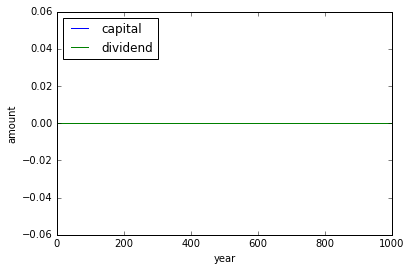

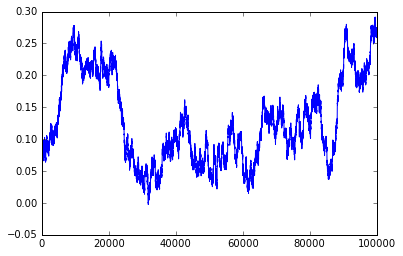

In [13]:
f = Firm("GOOG")

days = []
years = []
roe = []
capital = []
dividend = []

for anno in range(0, 1000):
    for day in range(0, year):
        f.adjustReturn()
        roe.append(f.getReturnOnEquity())
        days.append(day + anno * year)
    years.append(anno)
    dividend.append(f.generateEarnings())
    capital.append(f.getCapital())

plot.plot(years, capital, 'b', label='capital')
plot.plot(years, dividend, 'g', label='dividend')
plot.xlabel('year')
plot.ylabel('amount')
plot.legend(loc='upper left')
plot.show()

plot.plot(days, roe)
plot.show()


In [33]:
class LimitOrder:
    
    def __init__(self, wallet, limitPrice, position, shares):
        self.price = limitPrice
        self.wallet = wallet
        self.shares = shares
        self.position = position
        
    def transfer(self, sourcePos, targetPos, shares, sourceWallet, targetWallet):
        sourcePos.shares -= shares
        tragetPos.shares += shares
        self.shares -= shares;
        proceeds = shares * price
        sourceWallet.amount -= proceeds
        targetWallet.amount += proceeds

class Bid(LimitOrder):
    def __init__(self, wallet, limitPrice, position, shares):
        LimitOrder.__init__(self, wallet, limitPrice, position, shares)
        
    def execute(self, otherWallet, askedShares, otherPosition):
        shares = min(askedShares, otherPosition.shares, self.shares)
        transfer(otherPosition, self.position, shares, self.wallet, otherWallet)
        
    def isActive():
        return self.shares >= 0

class Ask(LimitOrder):
    def __init__(self, wallet, limitPrice, position, shares):
        LimitOrder.__init__(self, wallet, limitPrice, position, shares)
            
    def execute(self, otherWallet, bidShares, otherPosition):
        shares = min(bidShares, otherPosition.shares, self.shares)  
        transfer(self.position, otherPosition, shares, otherWallet, self.wallet)
        
    def isActive():
        return self.shares >= 0 and self.position.shares >= 0

In [34]:
def priceGetter(o):
    return o.price

class Orderbook:
    
    def __init__(self):
        self.bids = []
        self.asks = []
        
    def addLimitOrders(self, orders):
        for o in orders:
            if (isinstance(o, Ask)):
                self.asks.append(o)
            elif (isinstance(o, Bid)):
                self.bids.append(o)
        
    def hasBids(self):
        return getBestBid() is not None
    
    def hasAsks(self):
        return getBestAsk() is not None
    
    def getBestBid():
        return getBest(self.bids)
    
    def getBestAsk():
        return getBest(self.asks)
    
    def getBest(orders):
        if len(orders) == 0:
            return None
        b = bids[0]
        if (b.isActive()):
            return b
        else:
            orders.pop(0)
            return getBest(orders)
        
    def prepare(self):
        self.asks = sorted(self.asks, key=priceGetter, reverse=False)
        self.bids = sorted(self.bids, key=priceGetter, reverse=True)
        while(self.hasBids() and self.hasAsks() and self.getBestBid().price >= self.getBestAsk().price):
            b = self.getFirstBid()
            a = self.getFirstAsk()
            a.execute(b.wallet, b.shares, b.position)
        
        
m = Orderbook()
f1 = ListedFirm("GOOG")
m.addLimitOrders(f1.createLimitOrders())

m.bids
m.asks

    

In [27]:
class MarketParticipant:
    
    def __init__(self):
        self.portfolio = Portfolio()
    
    def createLimitOrders(self):
        return []
        
    def issueMarketOrders(self):
        return
    
class Position:
    
    def __init__(self, ticker):
        self.ticker = ticker
        self.shares = 0
    
class Portfolio:
    
    def __init__(self):
        self.positions = {}
        
    def getPosition(self, ticker):
        if (ticker not in self.positions):
            self.positions[ticker] = Position(ticker)
        return self.positions[ticker]
    
    def receiveDividend(ticker, amountPerShare):
        position = getPosition(ticker)
        if (position):
            return position.getShares() * amountPerShare
        else:
            return 0
    

In [23]:
class ListedFirm(Firm, MarketParticipant):
    
    def __init__(self, ticker):
        Firm.__init__(self, ticker)
        MarketParticipant.__init__(self)
        self.createdShares = 0

    def generateDividend(self):
        earnings = self.generateEarnings()
        return earnings / getOutstandingShares()
    
    def getOutstandingShares(self):
        return self.createdShares - self.portfolio.getPosition(self.ticker).shares;
    
    def createLimitOrders(self):
        position = self.portfolio.getPosition(self.ticker)
        delta = position.shares - 100
        position.shares = 100
        self.createdShares -= delta
        basePrice = self.capital.amount / self.createdShares
        return [Bid(self.capital, basePrice / 2, position, 100), Ask(self.capital, basePrice*2, position, 100)]
    